## 1. Problem Definition

> The goal of this project is to build an AI which will be able to recognize written digits accurately. 

## 2. Data

>The data is taken from Kaggle's Digit Recognzier competition. It contains a dataset of images of  hand written numbers. The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

>For more information about the competiton check out the page for it [here](https://www.kaggle.com/competitions/digit-recognizer/data)

## 3. Evaluation
>The evaluation metric for this contest is the categorization accuracy, or the proportion of test images that are correctly classified. For example, a categorization accuracy of 0.97 indicates that the AI classified all but 3% of the images.

## Imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PIL import Image
from IPython.display import display
import cv2

import keras
from keras import layers
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras_tuner.tuners import RandomSearch

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
gen = image.ImageDataGenerator()

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

import tensorflow_hub as hub

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Data Exploration

In [2]:
def read_csv_with_check(file_path, **kwargs):
    """
    Reads a CSV file if it exists, otherwise raises FileNotFoundError.

    Parameters:
    - file_path (str): The path to the CSV file.
    - **kwargs: Additional keyword arguments to be passed to pandas.read_csv.

    Returns:
    - DataFrame: A pandas DataFrame containing the data from the CSV file.

    Raises:
    - FileNotFoundError: If the specified file_path does not exist.
    """
    if os.path.exists(file_path):
        return pd.read_csv(file_path, **kwargs)
    else:
        raise FileNotFoundError(f"The file {file_path} does not exist.")


In [3]:
file_path = "/kaggle/input/digit-recognizer/train.csv"

try:
    train = read_csv_with_check(file_path, index_col=0)
except FileNotFoundError as e:
    print(e)
    
file_path = "/kaggle/input/digit-recognizer/test.csv"

try:
    test = read_csv_with_check(file_path, index_col=0)
except FileNotFoundError as e:
    print(e)

>First lets take a look at some of the sample images from the data set. Initially they are given as an array of integers so they will be converted back into grayscale images for us to view.

In [4]:
def get_image(df, row_index, width=28, height=28, rgb=False):
    '''
    This helper function allows the user to look at the images from the dataset look like.
    Originally they are a data frame of numbers representing each pixel but this function creates
    an image from these numbers which is shown to the user.
    
    df: Data frame
    row_index: Row of dataframe
    width: width of output image
    height: height of output image
    
    returns: None
    '''
    # Select the row based on the index
    selected_row = df.iloc[row_index]

    # Convert the selected row to a numpy array
    pixel_values = selected_row.values.astype('uint8')

    # Reshape the pixel values into an image
    if not rgb:
        reshaped_array = pixel_values.reshape((height, width))
    else: 
        reshaped_array = pixel_values.reshape((128, 128, 3))
        
    label = df.index[row_index]

    # Create a new figure
    plt.figure()

    # Plot the image
    if not rgb:
        plt.imshow(reshaped_array, cmap='gray')
    else:
        plt.imshow(reshaped_array)
        
    plt.axis('off')  # Turn off axis

    # Add a label indicating the number represented by the image
    plt.title(f'Number: {label}')

    # Show the plot
    plt.show()


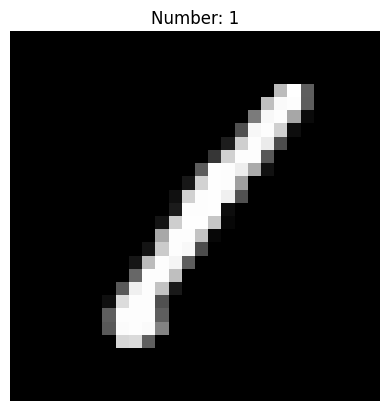

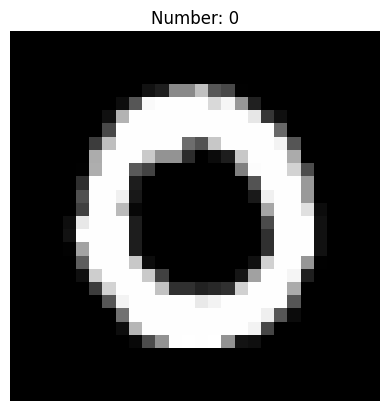

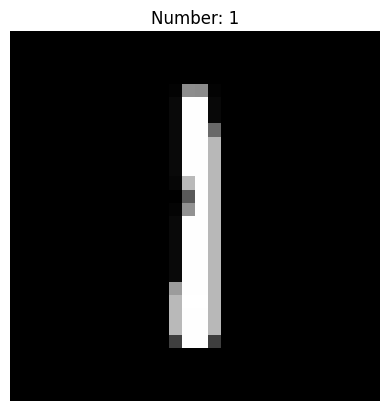

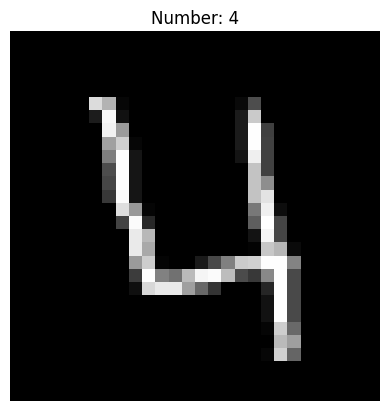

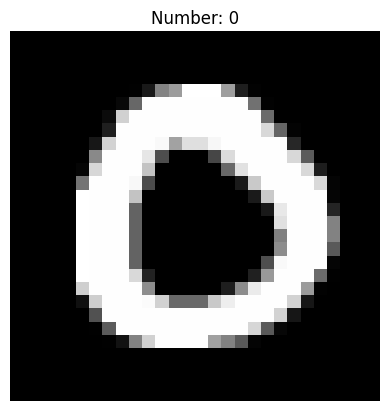

In [5]:
for i in range(5):
    get_image(train, i)

>Now lets get a good idea of the properties of the data frames

In [6]:
train.shape, test.shape

((42000, 784), (28000, 783))

In [7]:
train.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
label,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# Check if "label" is the index of the DataFrame
is_label_index = 'label' in train.index.names

if is_label_index:
    print("'label' is part of the index.")
else:
    print("'label' is not part of the index.")

'label' is part of the index.


In [9]:
train.dtypes

pixel0      int64
pixel1      int64
pixel2      int64
pixel3      int64
pixel4      int64
            ...  
pixel779    int64
pixel780    int64
pixel781    int64
pixel782    int64
pixel783    int64
Length: 784, dtype: object

In [10]:
train.shape

(42000, 784)

## Preprocessing Data
>In order to prepare these images for a model I will change pixel values from int64 to float32. Each image is 28x28 which can be kept. The training and data sets will also be batched

In [11]:
train = train.astype("float32")
test = test.astype("float32")

In [12]:
#Normalize data
train = train / 255.0
test = test / 255.0

In [13]:
# Extracting the index as labels and resetting the index
y = train.index.values  # Extracting the index as labels
X = train.reset_index(drop=True).values  # Resetting the index and using remaining columns as features

In [14]:
# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the training and validation data after splitting
X_train = X_train.reshape(-1, 28, 28, 1)
X_valid = X_valid.reshape(-1, 28, 28, 1)

## Model 0
>Lets begin with a simple neural network

In [15]:
# Define a simple CNN architecture
# Example model architecture
model_0 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [16]:
# Compile the model
model_0.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
#Callback functions
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('model_0.h5', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)


# Train the model
history = model_0.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, callbacks=[early_stopping, 
                                                                                                 checkpoint,
                                                                                                 reduce_lr])

Epoch 1/5
840/840 [==============================] - 5s 3ms/step - loss: 0.2852 - accuracy: 0.9145 - val_loss: 0.1531 - val_accuracy: 0.9548 - lr: 0.0010
Epoch 2/5
 66/840 [=>............................] - ETA: 1s - loss: 0.1395 - accuracy: 0.9583

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


840/840 [==============================] - 2s 3ms/step - loss: 0.1157 - accuracy: 0.9636 - val_loss: 0.1121 - val_accuracy: 0.9662 - lr: 0.0010
Epoch 3/5
840/840 [==============================] - 2s 3ms/step - loss: 0.0716 - accuracy: 0.9773 - val_loss: 0.1130 - val_accuracy: 0.9683 - lr: 0.0010
Epoch 4/5
840/840 [==============================] - 2s 3ms/step - loss: 0.0502 - accuracy: 0.9830 - val_loss: 0.1270 - val_accuracy: 0.9650 - lr: 0.0010
Epoch 5/5
840/840 [==============================] - 2s 3ms/step - loss: 0.0180 - accuracy: 0.9948 - val_loss: 0.0919 - val_accuracy: 0.9759 - lr: 2.0000e-04


In [18]:
def evaluate_classification_metrics(y_true, y_pred):
    '''
    Function to evaluate classification metrics and save them in a dictionary.
    
    y_true: Array of true labels
    y_pred: Array of predicted labels
    
    Returns a dictionary containing various classification metrics.
    '''
    # Calculate classification metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    # Save metrics in a dictionary
    metrics_dict = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    
    return metrics_dict

In [19]:
# Creating a dictionary which will hold all the results of our models
models = {}

In [20]:
# Load the best model saved by ModelCheckpoint
model_0 = tf.keras.models.load_model('model_0.h5')

# Predict on the test data
predictions = model_0.predict(X_valid)

# Get the predicted digit for each image
predicted_digits = np.argmax(predictions, axis=1) 

models["model_0"] = evaluate_classification_metrics(y_valid, predicted_digits)
models

263/263 [==============================] - 0s 1ms/step


{'model_0': {'accuracy': 0.9757142857142858,
  'precision': 0.9757672609083591,
  'recall': 0.9757142857142858,
  'f1': 0.9757142429549153}}

>We are off to a great start! Lets see how different models perform and if this score can be made even better.

## Model 1: Different Neural Network
>Lets try building a neural network with a different architecture and see how it stacks up to the first model.

In [21]:
# Define a new CNN architecture
model_1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
model_1.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Display the model summary
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 dense_3 (Dense)             (None, 128)              

In [22]:
checkpoint = ModelCheckpoint('model_1.h5', save_best_only=True)

# Train the model
history = model_1.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping, 
                                                                                                 checkpoint,
                                                                                                 reduce_lr])

Epoch 1/10
840/840 [==============================] - 6s 4ms/step - loss: 0.2070 - accuracy: 0.9355 - val_loss: 0.0774 - val_accuracy: 0.9790 - lr: 0.0010
Epoch 2/10
 53/840 [>.............................] - ETA: 2s - loss: 0.0876 - accuracy: 0.9741

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


840/840 [==============================] - 3s 3ms/step - loss: 0.0599 - accuracy: 0.9813 - val_loss: 0.0655 - val_accuracy: 0.9796 - lr: 0.0010
Epoch 3/10
840/840 [==============================] - 3s 4ms/step - loss: 0.0414 - accuracy: 0.9875 - val_loss: 0.0522 - val_accuracy: 0.9853 - lr: 0.0010
Epoch 4/10
840/840 [==============================] - 3s 3ms/step - loss: 0.0278 - accuracy: 0.9910 - val_loss: 0.0487 - val_accuracy: 0.9863 - lr: 0.0010
Epoch 5/10
840/840 [==============================] - 3s 3ms/step - loss: 0.0234 - accuracy: 0.9915 - val_loss: 0.0612 - val_accuracy: 0.9845 - lr: 0.0010
Epoch 6/10
840/840 [==============================] - 3s 3ms/step - loss: 0.0157 - accuracy: 0.9945 - val_loss: 0.0631 - val_accuracy: 0.9836 - lr: 0.0010
Epoch 7/10
840/840 [==============================] - 3s 3ms/step - loss: 0.0047 - accuracy: 0.9987 - val_loss: 0.0541 - val_accuracy: 0.9876 - lr: 2.0000e-04


In [23]:
# Load the best model saved by ModelCheckpoint
model_1 = tf.keras.models.load_model('model_1.h5')

In [24]:
# Predict on the test data
predictions = model_1.predict(X_valid)

# Get the predicted digit for each image
predicted_digits = np.argmax(predictions, axis=1) 

models["model_1"] = evaluate_classification_metrics(y_valid, predicted_digits)
models

263/263 [==============================] - 0s 2ms/step


{'model_0': {'accuracy': 0.9757142857142858,
  'precision': 0.9757672609083591,
  'recall': 0.9757142857142858,
  'f1': 0.9757142429549153},
 'model_1': {'accuracy': 0.9861904761904762,
  'precision': 0.9862996868662748,
  'recall': 0.9861904761904762,
  'f1': 0.9862004482600683}}

>It looks like this model is doing even better. Lets see these diffrences in metrics in a more visual way.

In [25]:
def plot_model_scores(models_dict):
    '''
    Function to plot bar graphs highlighting different scores from a dictionary of models.

    models_dict: Dictionary containing model names as keys and their scores as values.
    
    Returns None
    '''
    # Extract model names and scores
    model_names = list(models_dict.keys())
    scores = list(models_dict.values())

    # Extract score names
    score_names = list(scores[0].keys())

    # Set colors for each model
    cmap = plt.colormaps.get_cmap("rainbow")
    colors = cmap(np.linspace(0, 1, len(model_names)))

    # Plot each score
    for score_name in score_names:
        score_values = [model[score_name] for model in scores]

        # Plot bar graph
        plt.figure(figsize=(8, 6))
        bars = plt.bar(model_names, score_values, color=colors)

        # Adjust y-axis limits
        plt.ylim(0.9, 1.0)

        # Add score values above the bars
        for bar, value in zip(bars, score_values):
            plt.text(bar.get_x() + bar.get_width() / 2, value + 0.005, f'{value:.3f}', ha='center', va='bottom')

        plt.xlabel('Model')
        plt.ylabel(score_name.capitalize())  # Capitalize score name
        plt.title(f'{score_name.capitalize()} Comparison Between Models')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

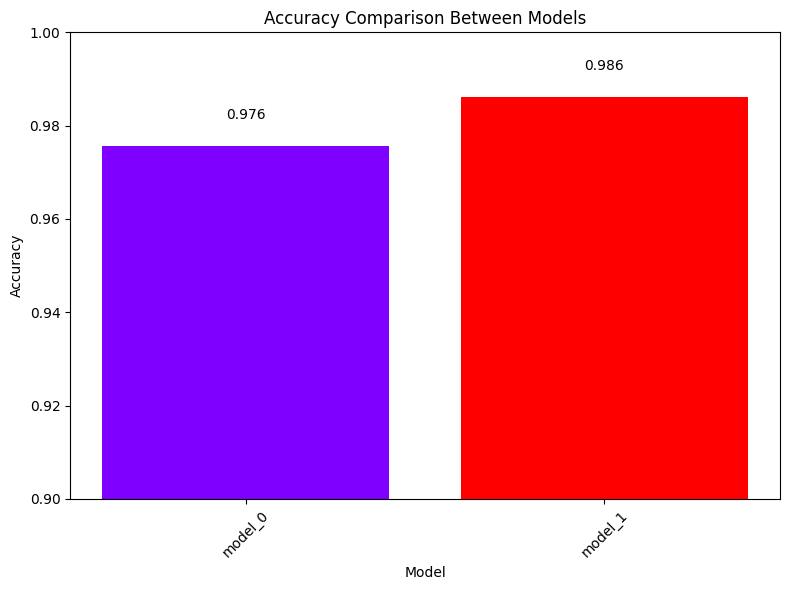

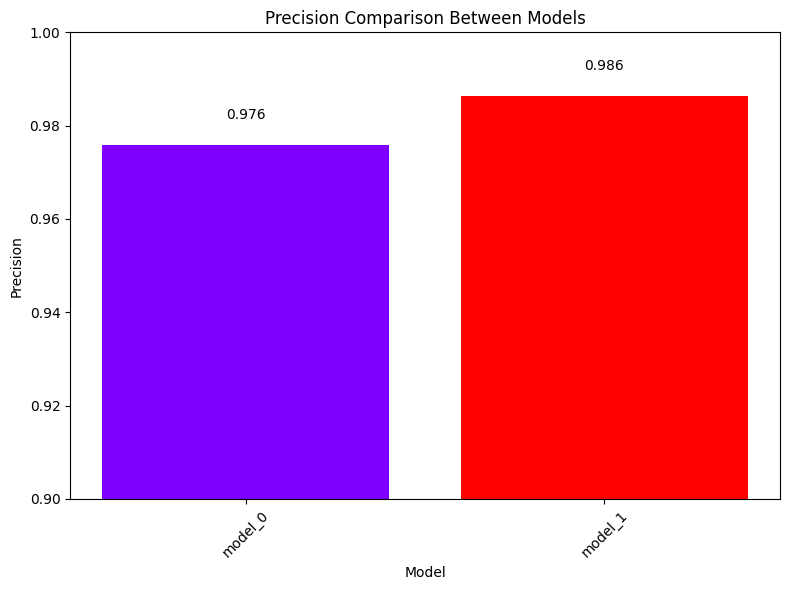

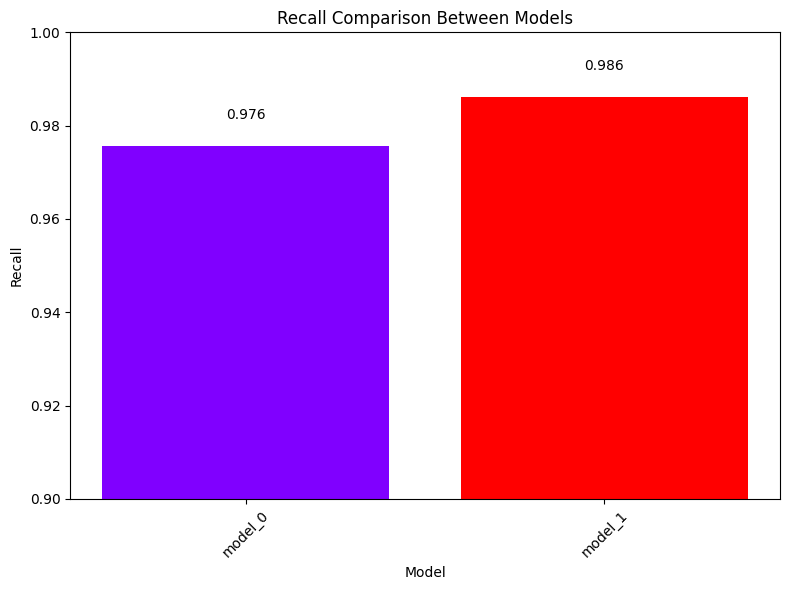

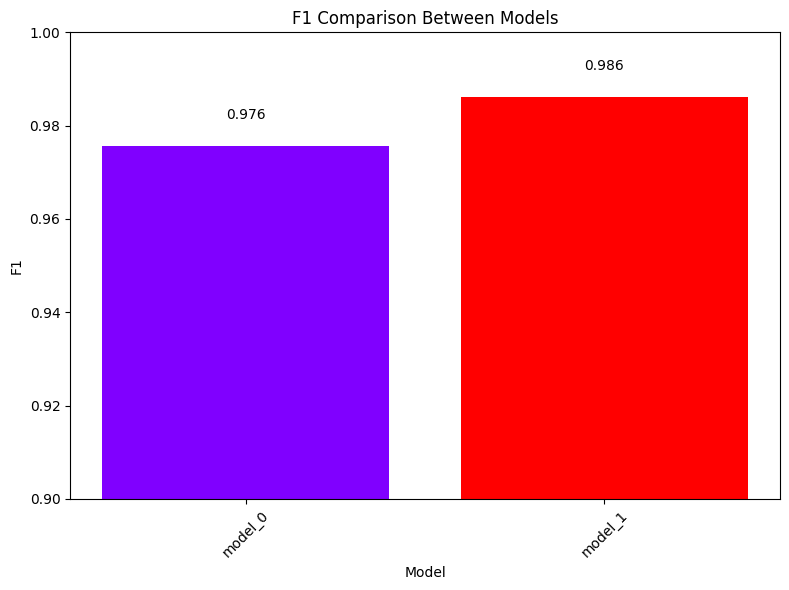

In [26]:
plot_model_scores(models)

>Lets see what happens if some of the layers in model_1 are modified

## Model 2: Modified Model 1

In [27]:
# Define a new CNN architecture - lets see what happens if we make the model a little lighter.
# Perhaps there will be improved performance with a faster training time?
model_2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
model_2.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Display the model summary
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 5408)              0         
                                                                 
 dense_5 (Dense)             (None, 64)                346176    
                                                                 
 dense_6 (Dense)             (None, 10)                650       
                                                                 
Total params: 347146 (1.32 MB)
Trainable params: 347146 (1.32 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [28]:
checkpoint = ModelCheckpoint('model_2.h5', save_best_only=True)

# Train the model
history = model_2.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping, 
                                                                                                 checkpoint,
                                                                                                 reduce_lr])

Epoch 1/10
840/840 [==============================] - 4s 3ms/step - loss: 0.2711 - accuracy: 0.9187 - val_loss: 0.1228 - val_accuracy: 0.9661 - lr: 0.0010
Epoch 2/10
 60/840 [=>............................] - ETA: 2s - loss: 0.1128 - accuracy: 0.9682

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


840/840 [==============================] - 3s 3ms/step - loss: 0.0867 - accuracy: 0.9735 - val_loss: 0.0839 - val_accuracy: 0.9787 - lr: 0.0010
Epoch 3/10
840/840 [==============================] - 3s 3ms/step - loss: 0.0543 - accuracy: 0.9826 - val_loss: 0.0871 - val_accuracy: 0.9746 - lr: 0.0010
Epoch 4/10
840/840 [==============================] - 3s 3ms/step - loss: 0.0379 - accuracy: 0.9878 - val_loss: 0.0926 - val_accuracy: 0.9714 - lr: 0.0010
Epoch 5/10
840/840 [==============================] - 3s 3ms/step - loss: 0.0177 - accuracy: 0.9955 - val_loss: 0.0638 - val_accuracy: 0.9839 - lr: 2.0000e-04
Epoch 6/10
840/840 [==============================] - 3s 3ms/step - loss: 0.0129 - accuracy: 0.9971 - val_loss: 0.0637 - val_accuracy: 0.9851 - lr: 2.0000e-04
Epoch 7/10
840/840 [==============================] - 3s 3ms/step - loss: 0.0110 - accuracy: 0.9977 - val_loss: 0.0640 - val_accuracy: 0.9844 - lr: 2.0000e-04
Epoch 8/10
840/840 [==============================] - 3s 3ms/step - l

263/263 [==============================] - 0s 2ms/step


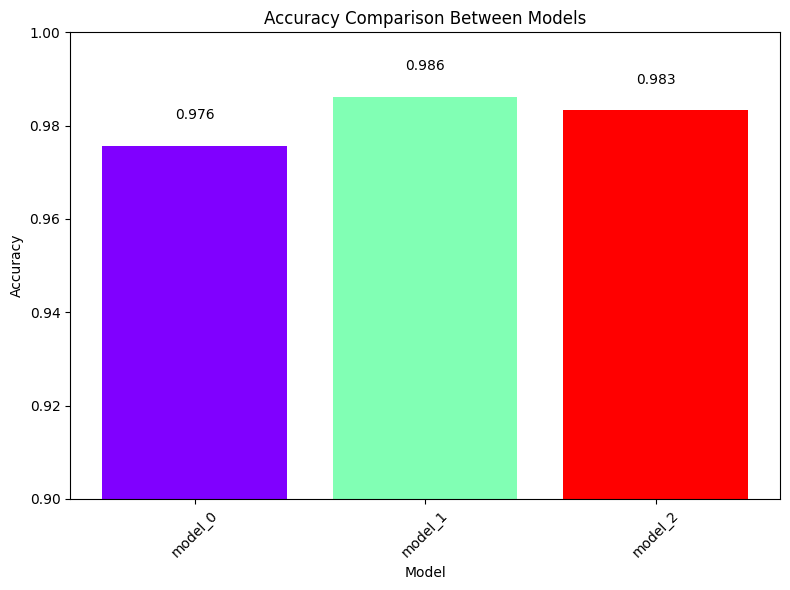

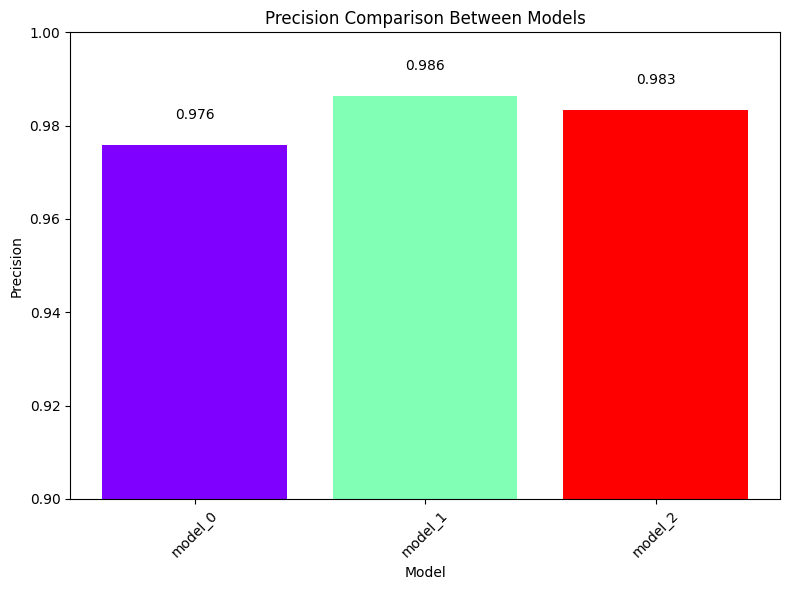

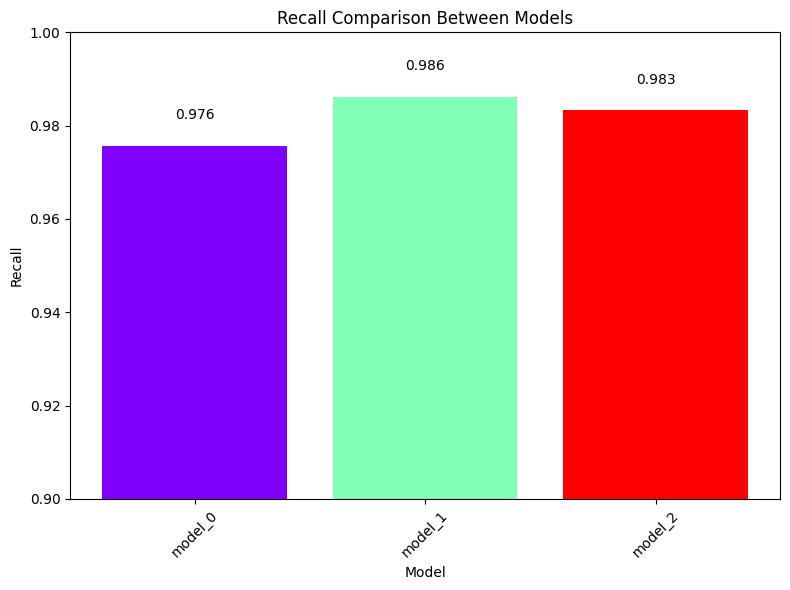

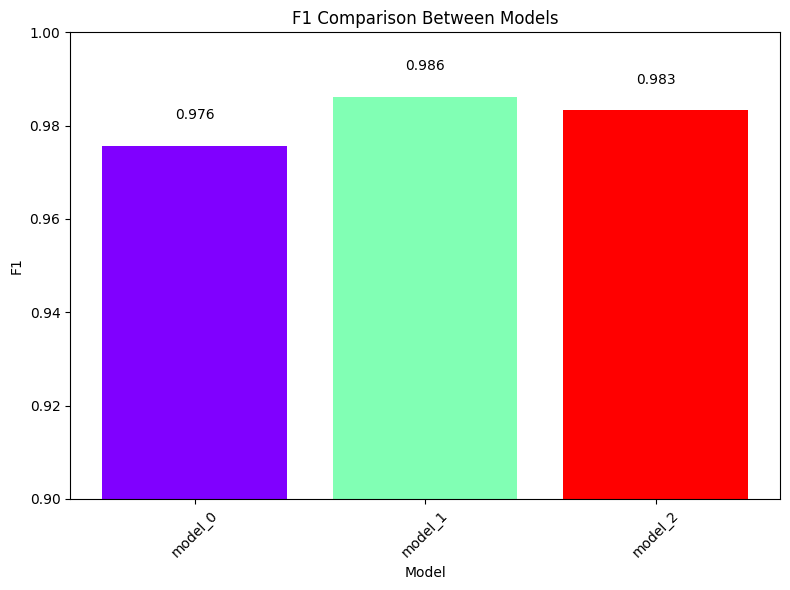

In [29]:
# Predict on the test data
predictions = model_2.predict(X_valid)

# Get the predicted digit for each image
predicted_digits = np.argmax(predictions, axis=1)

models["model_2"] = evaluate_classification_metrics(y_valid, predicted_digits)

plot_model_scores(models)

>Overall it is performing a bit worse than the previous model, but it did train faster and the scores are comparable. Lets try out some transfer learning.

## Model 3: mobilenet_v2

>Typically, these transfer learning models expect the input data to be in RGB format. While we could simply modify the layer to accept the grayscale images I have been working with, I think it would be better to simply adjust my images to RGB. This way, the transfer model will be more in line with its original intention. 

In [30]:
#Reimporting training data so it can be converted to RGB from scratch
file_path = "/kaggle/input/digit-recognizer/train.csv"

try:
    train = read_csv_with_check(file_path, index_col=0)
except FileNotFoundError as e:
    print(e)

In [31]:
grayscale_pixels = train.values

# Convert grayscale images to RGB
rgb_images = np.repeat(grayscale_pixels[..., np.newaxis], 3, axis=-1)

# Convert back to DataFrame and add labels
rgb_data = pd.DataFrame(rgb_images.reshape(-1, 28 * 28 * 3), columns=[f'pixel{i}' for i in range(28 * 28 * 3)])

rgb_data.index = train.index

rgb_data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel2342,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351
label,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
# Assuming the original grayscale images are 28x28 pixels
original_image_size = 28 * 28
target_image_size = 128

# Assuming grayscale_pixels has shape (num_images, original_image_size)
# and contains the grayscale pixel values
grayscale_pixels = train.values

# Reshape grayscale images to (num_images, 28, 28) for resizing
grayscale_images = grayscale_pixels.reshape(-1, 28, 28)

# Initialize an array to store resized RGB images
resized_rgb_images = np.zeros((grayscale_images.shape[0], target_image_size, target_image_size, 3), dtype=np.uint8)

# Iterate through each grayscale image, resize it to 128x128, and convert to RGB
for i, img in enumerate(grayscale_images):
    # Ensure the input image is in uint8 format
    img = img.astype(np.uint8)
    
    # Resize grayscale image to 128x128
    resized_img = cv2.resize(img, (target_image_size, target_image_size))
    
    # Convert resized image to RGB
    rgb_img = cv2.cvtColor(resized_img, cv2.COLOR_GRAY2RGB)
    
    # Store the RGB image in the array
    resized_rgb_images[i] = rgb_img

# Flatten the array of RGB images
flattened_images = resized_rgb_images.reshape(-1, target_image_size * target_image_size * 3)

# Convert to DataFrame and add labels
rgb_data = pd.DataFrame(flattened_images, columns=[f'pixel{i}' for i in range(target_image_size * target_image_size * 3)])
rgb_data.index = train.index

rgb_data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel49142,pixel49143,pixel49144,pixel49145,pixel49146,pixel49147,pixel49148,pixel49149,pixel49150,pixel49151
label,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
rgb_data.shape

(42000, 49152)

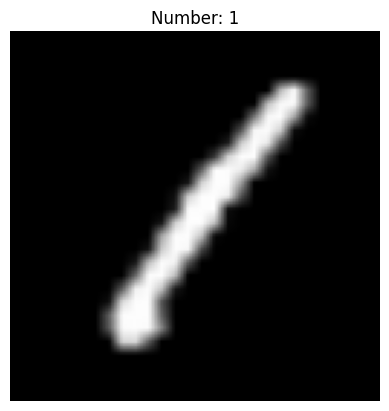

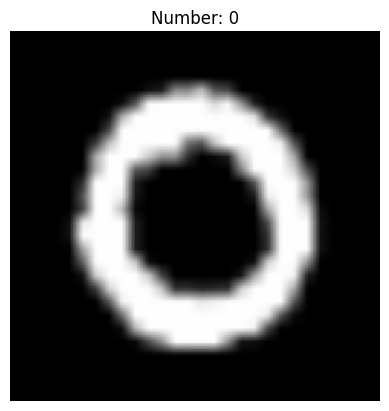

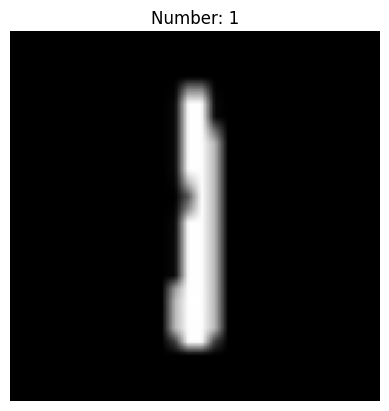

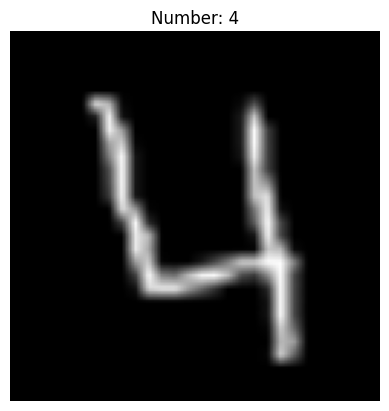

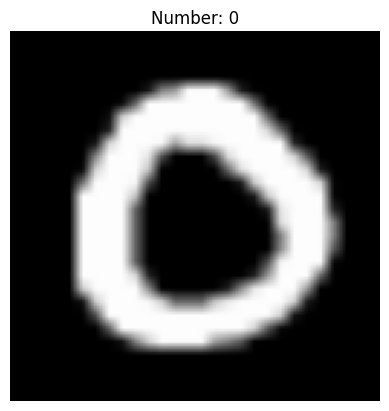

In [34]:
for i in range(5):
    get_image(rgb_data, i, rgb=True)

>The conversion is a success! Now lets finish preprocessing the data

In [35]:
train_rgb = rgb_data

# Extracting the index as labels and resetting the index
y = train_rgb.index.values  # Extracting the index as labels
X = train_rgb.reset_index(drop=True).values  # Resetting the index and using remaining columns as features

In [36]:
# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the training and validation data after splitting
X_train = X_train.reshape(-1, 128, 128, 3)
X_valid = X_valid.reshape(-1, 128, 128, 3)

In [37]:
model_3 = tf.keras.Sequential([
    hub.KerasLayer("https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/035-128-classification/versions/2"),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')  # 10 classes for digits 0-9
])

model_3.build([None, 128, 128, 3])  # Batch input shape.

In [38]:
model_3.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

In [39]:
checkpoint = ModelCheckpoint('model_3.h5', save_best_only=True)

# Train the model
history = model_3.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping, 
                                                                                                 checkpoint,
                                                                                                 reduce_lr])

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


840/840 [==============================] - 12s 9ms/step - loss: 0.3512 - accuracy: 0.8884 - val_loss: 0.2504 - val_accuracy: 0.9205 - lr: 0.0010
Epoch 2/10


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


840/840 [==============================] - 6s 7ms/step - loss: 0.2160 - accuracy: 0.9283 - val_loss: 0.3268 - val_accuracy: 0.8966 - lr: 0.0010
Epoch 3/10
840/840 [==============================] - 7s 8ms/step - loss: 0.1892 - accuracy: 0.9357 - val_loss: 0.2037 - val_accuracy: 0.9363 - lr: 0.0010
Epoch 4/10
840/840 [==============================] - 6s 7ms/step - loss: 0.1712 - accuracy: 0.9428 - val_loss: 0.2155 - val_accuracy: 0.9357 - lr: 0.0010
Epoch 5/10
840/840 [==============================] - 6s 8ms/step - loss: 0.1497 - accuracy: 0.9492 - val_loss: 0.2018 - val_accuracy: 0.9369 - lr: 0.0010
Epoch 6/10
840/840 [==============================] - 6s 8ms/step - loss: 0.1460 - accuracy: 0.9501 - val_loss: 0.1733 - val_accuracy: 0.9510 - lr: 0.0010
Epoch 7/10
840/840 [==============================] - 6s 7ms/step - loss: 0.1371 - accuracy: 0.9529 - val_loss: 0.1936 - val_accuracy: 0.9421 - lr: 0.0010
Epoch 8/10
840/840 [==============================] - 6s 8ms/step - loss: 0.1264 

263/263 [==============================] - 2s 6ms/step


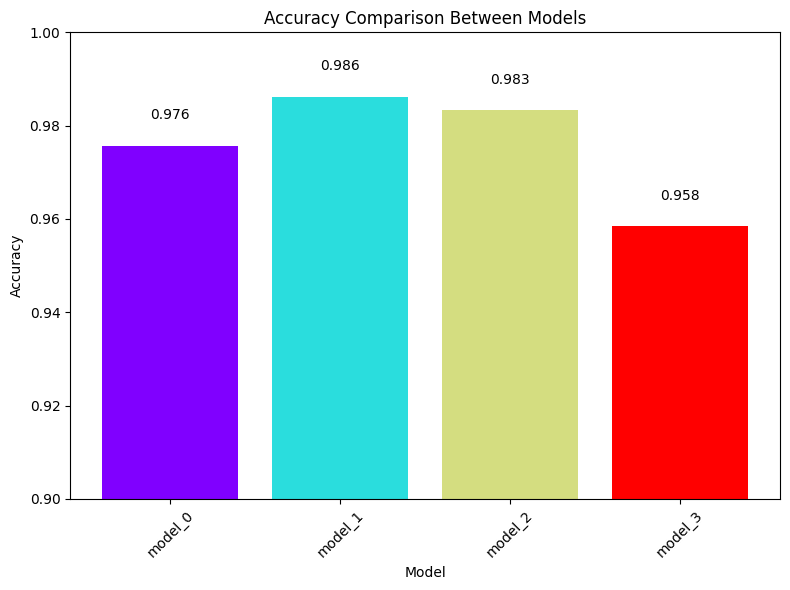

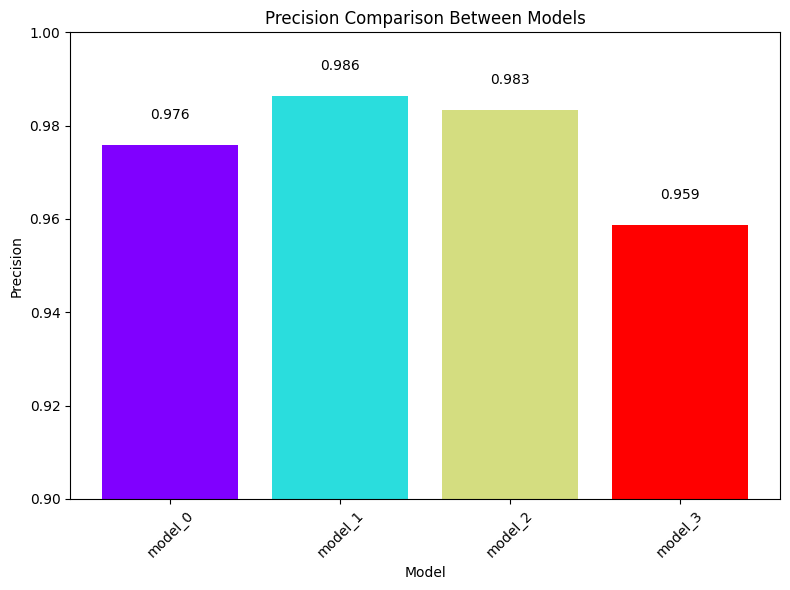

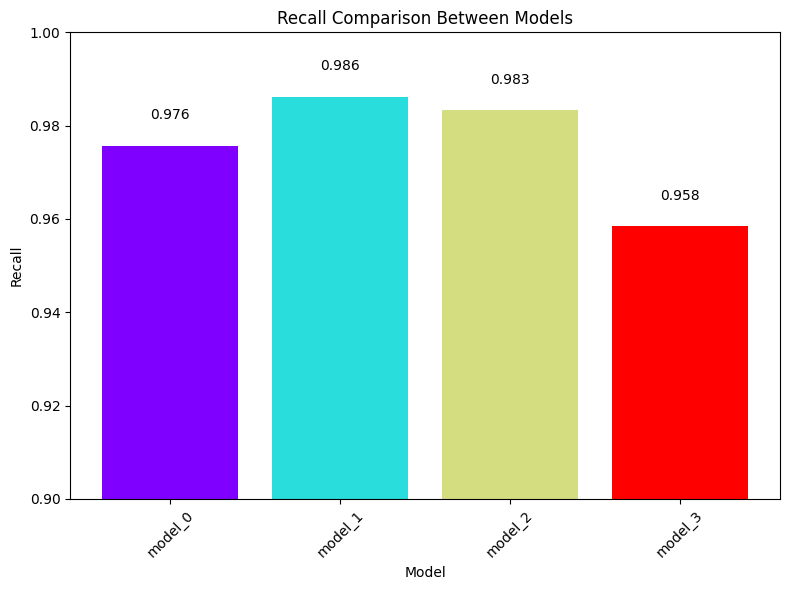

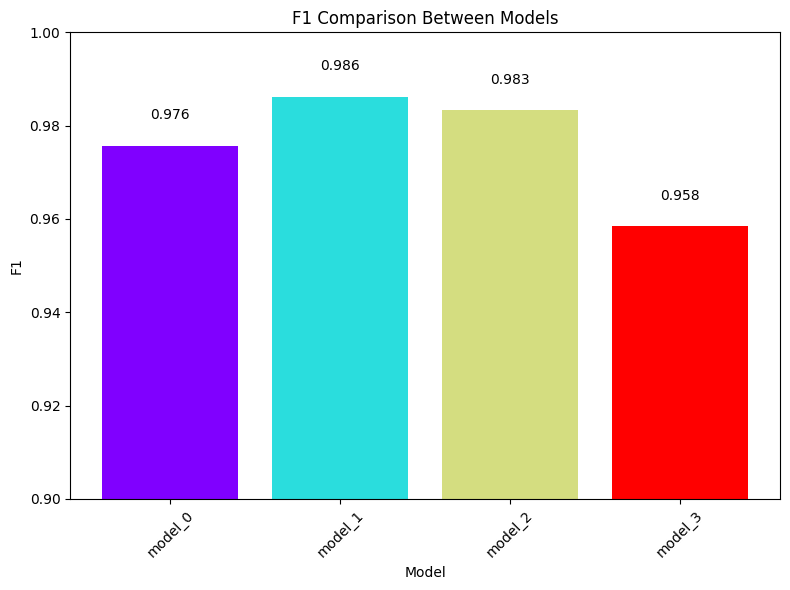

In [40]:
# Predict on the test data
predictions = model_3.predict(X_valid)

# Get the predicted digit for each image
predicted_digits = np.argmax(predictions, axis=1)

models["model_3"] = evaluate_classification_metrics(y_valid, predicted_digits)

plot_model_scores(models)

>While it is important to keep in mind that all these models are doing great as all their accuracies are above 95%, it seems that the mobilenet model has performed the worst so fall. I believe for a simple problem like this, mobilenet is just too advanced of a tool to use. Its complex architecture is likely causing an overlearning problem on a dataset with something as basic as hand written numbers. 

## Model 4: Hypertuning Model 1

>So far Model 1 has perfomed the best, lets see if hypertuning can make it even better. Lets take a moment to be reminded of Model 1's architecture.

In [41]:
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 dense_3 (Dense)             (None, 128)              

In [42]:
#Setting up a function to test out different hyperparameters 
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Conv2D(hp.Int('conv1_units', min_value=16, max_value=128, step=16),
                            kernel_size=(3, 3),
                            activation='relu',
                            input_shape=(28, 28, 1)))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(hp.Int('conv2_units', min_value=16, max_value=128, step=16),
                            kernel_size=(3, 3),
                            activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(hp.Int('dense_units', min_value=32, max_value=256, step=32),
                           activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

>Due to the RGB conversion that happened in the last model, the data will need to be processd to work with the grayscale images again.

In [43]:
file_path = "/kaggle/input/digit-recognizer/train.csv"

try:
    train = read_csv_with_check(file_path, index_col=0)
except FileNotFoundError as e:
    print(e)
    
train = train.astype("float32")
train = train / 255.0


# Extracting the index as labels and resetting the index
y = train.index.values  # Extracting the index as labels
X = train.reset_index(drop=True).values  # Resetting the index and using remaining columns as features

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the training and validation data after splitting
X_train = X_train.reshape(-1, 28, 28, 1)
X_valid = X_valid.reshape(-1, 28, 28, 1)

In [44]:
# Initialize a tuner for random search
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=50,
    directory='grid_search',
    project_name='mnist_random_0'
)

# Perform hypertuning
tuner.search(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

# Get the best hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps}")

# Build the model with the best hyperparameters
model_4 = tuner.hypermodel.build(best_hps)

Trial 50 Complete [00h 00m 17s]
val_accuracy: 0.9852678775787354

Best val_accuracy So Far: 0.9882440567016602
Total elapsed time: 00h 15m 04s
Best Hyperparameters: <keras_tuner.engine.hyperparameters.hyperparameters.HyperParameters object at 0x78293341e6b0>


In [45]:
checkpoint = ModelCheckpoint('model_4.h5', save_best_only=True)

# Train the model
history = model_4.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping, 
                                                                                                 checkpoint,
                                                                                                 reduce_lr])

Epoch 1/10
840/840 [==============================] - 5s 4ms/step - loss: 0.1807 - accuracy: 0.9442 - val_loss: 0.0724 - val_accuracy: 0.9792 - lr: 0.0010
Epoch 2/10
 52/840 [>.............................] - ETA: 2s - loss: 0.0468 - accuracy: 0.9820

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


840/840 [==============================] - 3s 4ms/step - loss: 0.0536 - accuracy: 0.9828 - val_loss: 0.0612 - val_accuracy: 0.9838 - lr: 0.0010
Epoch 3/10
840/840 [==============================] - 3s 4ms/step - loss: 0.0368 - accuracy: 0.9882 - val_loss: 0.0501 - val_accuracy: 0.9856 - lr: 0.0010
Epoch 4/10
840/840 [==============================] - 3s 3ms/step - loss: 0.0243 - accuracy: 0.9914 - val_loss: 0.0466 - val_accuracy: 0.9875 - lr: 0.0010
Epoch 5/10
840/840 [==============================] - 3s 3ms/step - loss: 0.0214 - accuracy: 0.9932 - val_loss: 0.0527 - val_accuracy: 0.9860 - lr: 0.0010
Epoch 6/10
840/840 [==============================] - 3s 3ms/step - loss: 0.0153 - accuracy: 0.9948 - val_loss: 0.0587 - val_accuracy: 0.9853 - lr: 0.0010
Epoch 7/10
840/840 [==============================] - 3s 3ms/step - loss: 0.0045 - accuracy: 0.9989 - val_loss: 0.0551 - val_accuracy: 0.9884 - lr: 2.0000e-04


In [46]:
# Predict on the test data
predictions = model_4.predict(X_valid)

# Get the predicted digit for each image
predicted_digits = np.argmax(predictions, axis=1) 


models["model_4"] = evaluate_classification_metrics(y_valid, predicted_digits)

models

263/263 [==============================] - 0s 2ms/step


{'model_0': {'accuracy': 0.9757142857142858,
  'precision': 0.9757672609083591,
  'recall': 0.9757142857142858,
  'f1': 0.9757142429549153},
 'model_1': {'accuracy': 0.9861904761904762,
  'precision': 0.9862996868662748,
  'recall': 0.9861904761904762,
  'f1': 0.9862004482600683},
 'model_2': {'accuracy': 0.9833333333333333,
  'precision': 0.9833675344971252,
  'recall': 0.9833333333333333,
  'f1': 0.9833409176086081},
 'model_3': {'accuracy': 0.958452380952381,
  'precision': 0.9586750951718216,
  'recall': 0.958452380952381,
  'f1': 0.9584340417017648},
 'model_4': {'accuracy': 0.9885714285714285,
  'precision': 0.9886204586757542,
  'recall': 0.9885714285714285,
  'f1': 0.9885686965690036}}

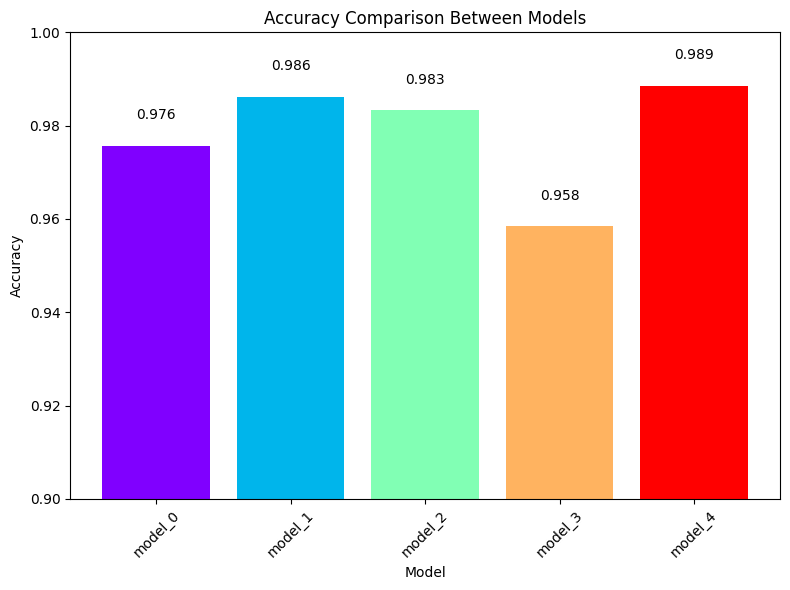

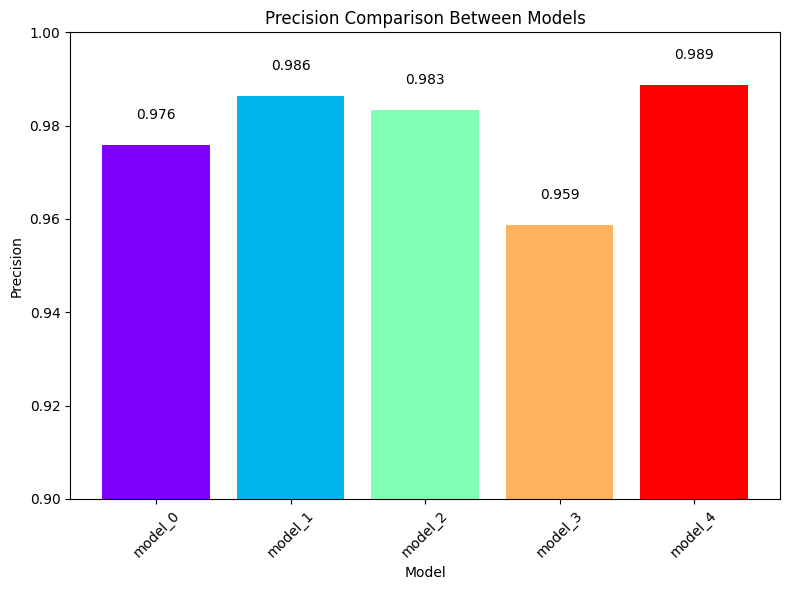

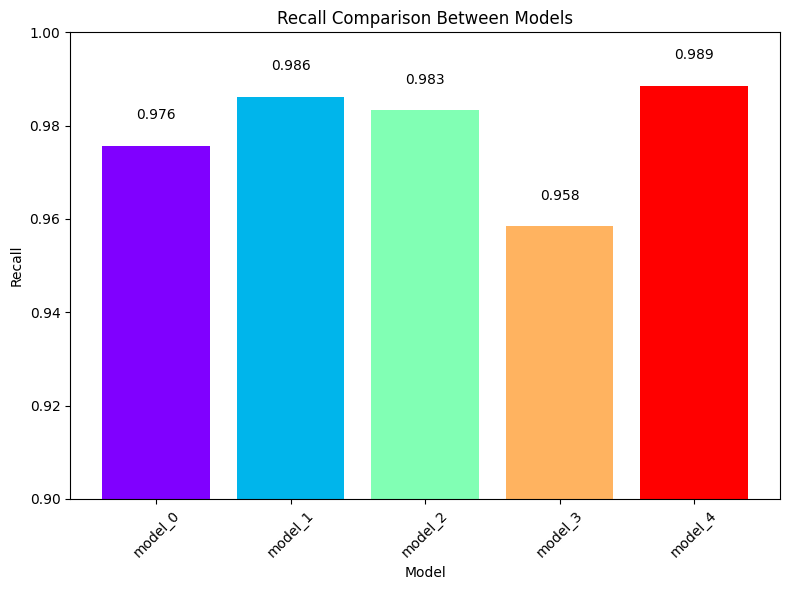

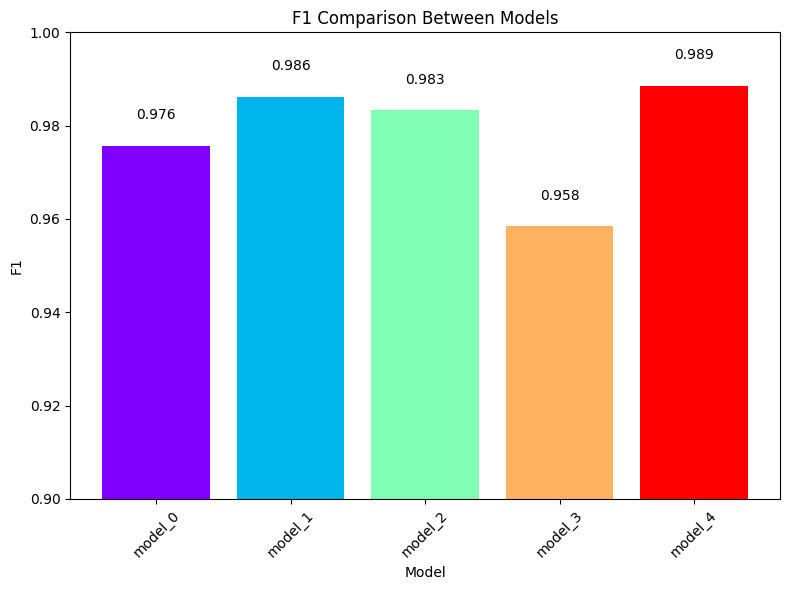

In [47]:
plot_model_scores(models)

## Summary

>In this notebook, some very accurate models have been made! It appears with this data, a smller neural network performs better than using transfer learning with a model like mobilenet_v2. This is likely due to the relative simplicity of the problem not benefiting from a very complex architecture like what is seen in many of the more popular CNN models. 